In [32]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

#print(model.summary())

imageOrig = tf.keras.preprocessing.image.load_img('D:/Master Thesis/Repo/Test Images/tabby.2.jpg', target_size=(224, 224))
imageArr = tf.keras.preprocessing.image.img_to_array(imageOrig)  #output Numpy-array

imageReshaped = imageArr.reshape((1, imageArr.shape[0], imageArr.shape[1], imageArr.shape[2]))

image = preprocess_input(imageReshaped)
predictions = model.predict(imageReshaped)

import numpy as np
top5predictions = np.argsort(predictions)[0,::-1][:5]

labels = decode_predictions(predictions, 15)

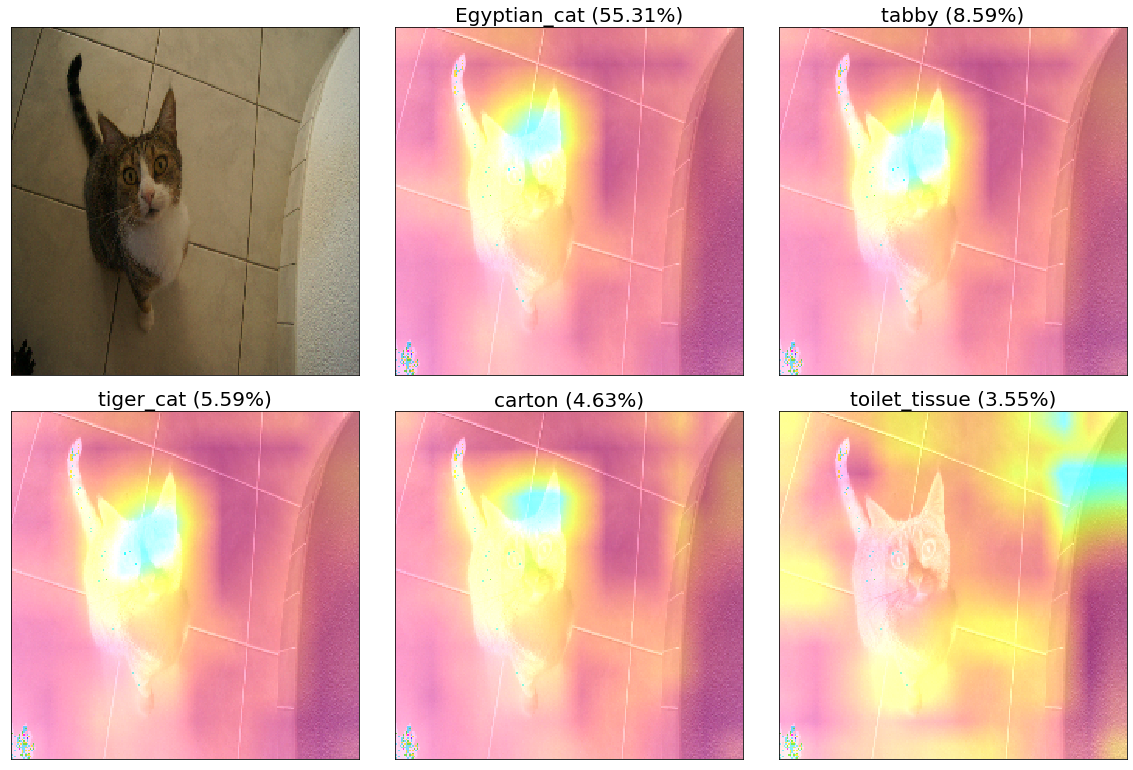

In [22]:
from tf_explain.core.grad_cam import GradCAM
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import cv2

def createImageGrid(imageOrig, predictions, labels, explainer, explainerArgs):
    camImages = [imageOrig]
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),
                 axes_pad=0.5,  # pad between axes in inch.
                 )
    for class_index in top5predictions:
        camImages.append(explainer.explain(class_index=class_index, **explainerArgs))
    
    i = -1
    for ax, im in zip(grid, camImages):
        # Iterating over the grid returns the Axes.
        ax.set_xticks([])
        ax.set_yticks([])
        label = labels[0][i]
        if i >= 0:
            ax.set_title('%s (%.2f%%)' % (label[1], label[2]*100), fontsize=20)
            ax.imshow(cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
        else:
            ax.imshow(im)
        i = i + 1

    plt.show()

img = tf.keras.preprocessing.image.img_to_array(imageOrig)
data = ([img], None)
    
explainer = GradCAM()
createImageGrid(imageOrig, predictions, labels, explainer, {'model': model, 'layer_name': 'block5_conv3', 'validation_data': data})

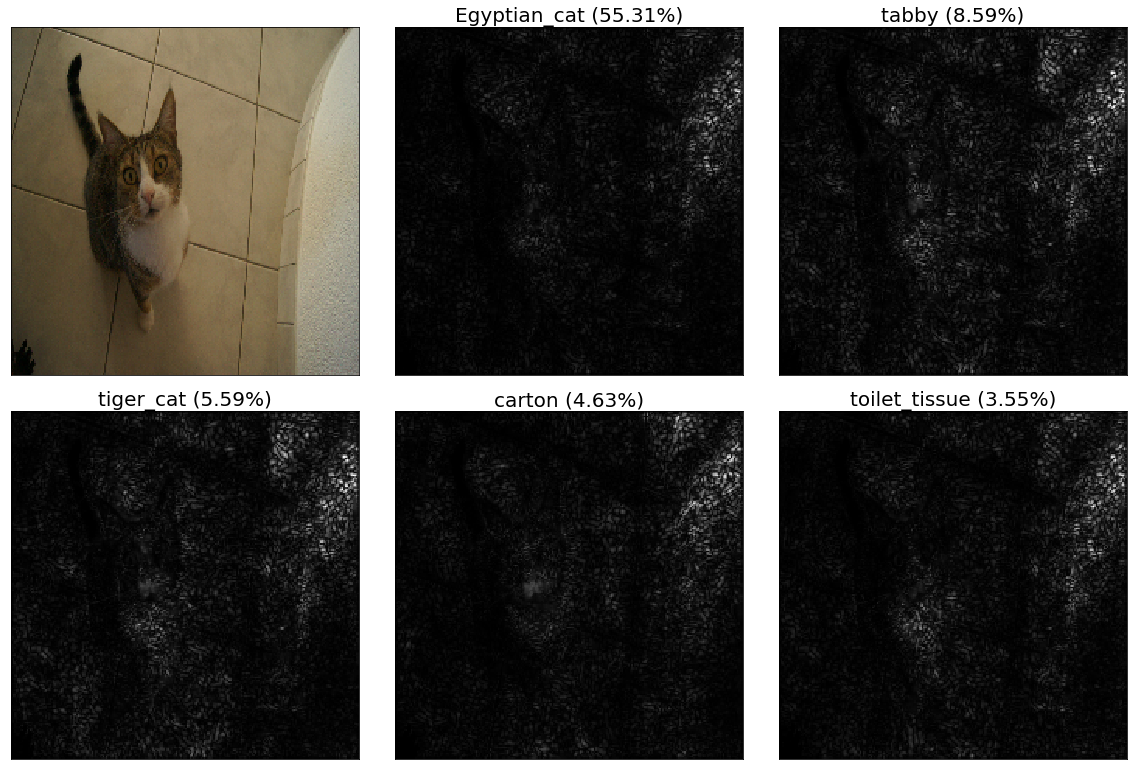

In [27]:
from tf_explain.core.gradients_inputs import GradientsInputs

img = tf.keras.preprocessing.image.img_to_array(imageOrig)
data = (np.array([img]), None)

explainer = GradientsInputs()
createImageGrid(imageOrig, predictions, labels, explainer, {'model': model, 'validation_data': data})

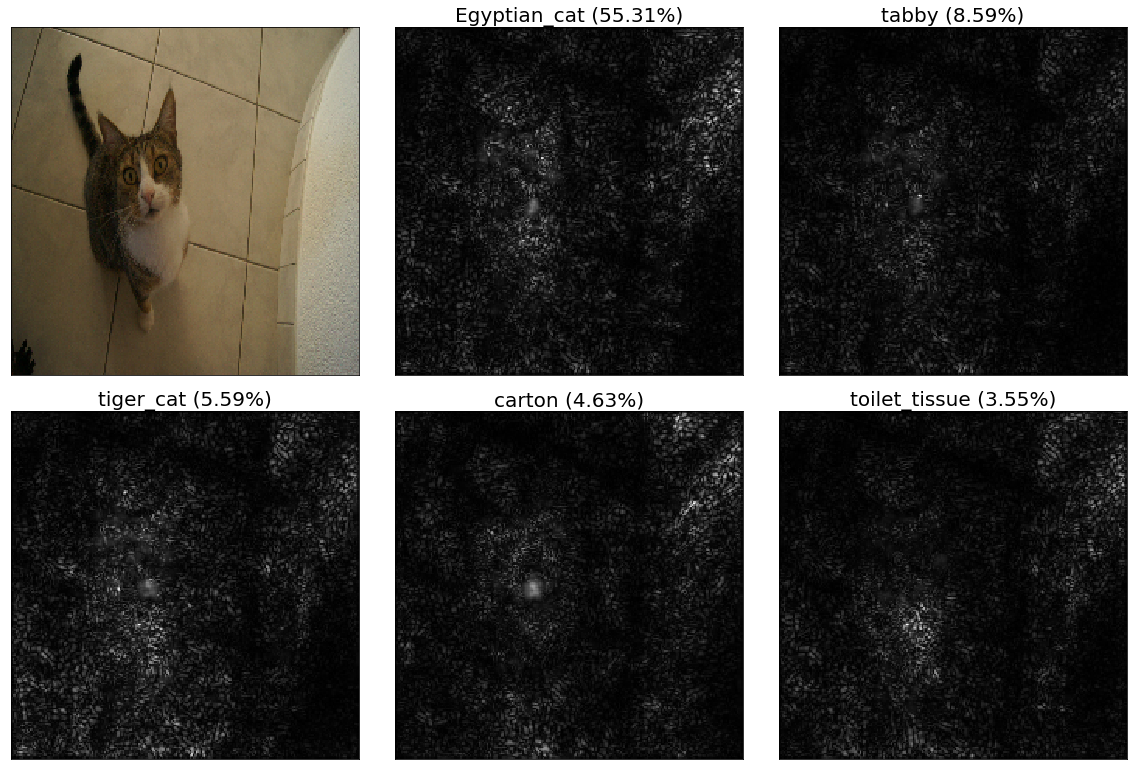

In [28]:
from tf_explain.core.integrated_gradients import IntegratedGradients

img = tf.keras.preprocessing.image.img_to_array(imageOrig)
data = ([img], None)

explainer = IntegratedGradients()
createImageGrid(imageOrig, predictions, labels, explainer, {'model': model, 'validation_data': data})

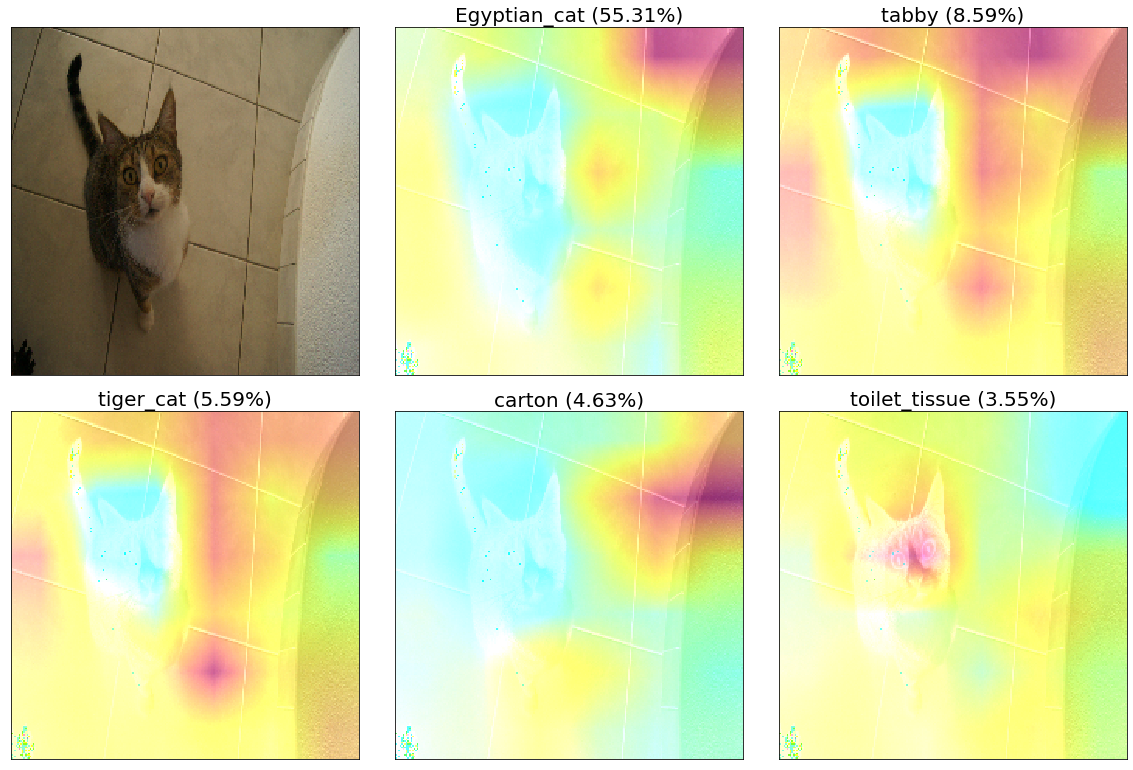

In [30]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

img = tf.keras.preprocessing.image.img_to_array(imageOrig)
data = ([img], None)

explainer = OcclusionSensitivity()
createImageGrid(imageOrig, predictions, labels, explainer, {'model': model, 'validation_data': data, 'patch_size': 40})

In [34]:
import lime 
from lime import lime_image

imgAsArray = tf.keras.preprocessing.image.img_to_array(imageOrig)
out = []
x = np.expand_dims(imgAsArray, axis=0)
x = preprocess_input(x)
out.append(x)
imagesStack = np.vstack(out)
            
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(imagesStack[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

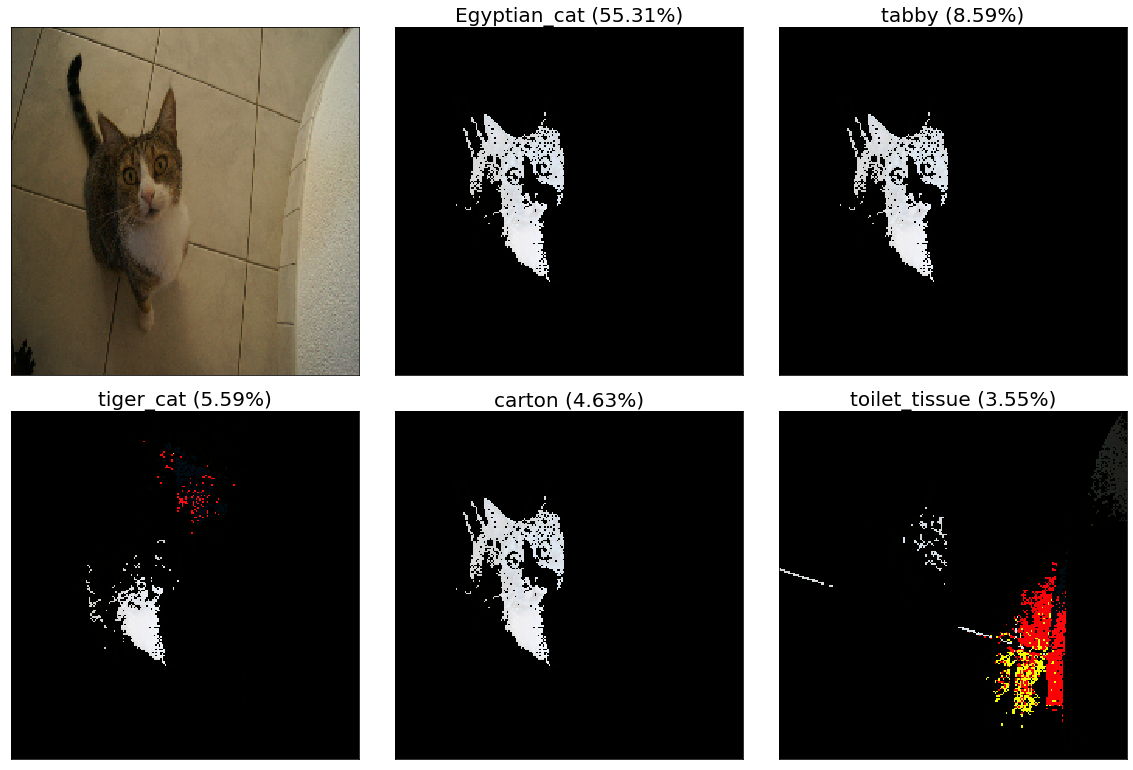

In [37]:
from skimage.segmentation import mark_boundaries

camImages = [imageOrig]
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
             nrows_ncols=(2, 3),
             axes_pad=0.5,  # pad between axes in inch.
             )
for class_index in range(0,5):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[class_index], positive_only=True, num_features=5, hide_rest=True)
    camImages.append(mark_boundaries(temp / 2 + 0.5, mask))

i = -1
for ax, im in zip(grid, camImages):
    # Iterating over the grid returns the Axes.
    ax.set_xticks([])
    ax.set_yticks([])
    label = labels[0][i]
    if i >= 0:
        ax.set_title('%s (%.2f%%)' % (label[1], label[2]*100), fontsize=20)
        ax.imshow(im.astype(np.uint8))
    else:
        ax.imshow(im)
    i = i + 1

plt.show()